# TD: Arbres de décisions et forêts aléatoires

Dans ce TD, on étudie les arbres et les forêts aléatoires dans un contexte de classification binaire.

On imagine que mon équipe a récupéré un vaste jeu de données sur 5 ans où je dispose d'un grand nombre d'indicateurs continus et discrets qui caractérisent des entreprises américaines. 

Je dois, à partir de ce jeu de donnée, créer un modèle qui va prédire la hausse ou la baisse du cours de l'action de l'entreprise. L'objectif est de pouvoir utiliser ce modèle plus tard pour prendre des décisions en amont sur l'investissement ou non dans telles ou telles entreprises. 

L'objectif est de proposer le meilleur modèle possible.

In [1]:
import pandas as pd 
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = {"2014" : pd.read_csv("TD3 - data/2014_Financial_Data.csv", index_col="Unnamed: 0"), 
        "2015" : pd.read_csv("TD3 - data/2015_Financial_Data.csv", index_col="Unnamed: 0"), 
        "2016" : pd.read_csv("TD3 - data/2016_Financial_Data.csv", index_col="Unnamed: 0"), 
        "2017" : pd.read_csv("TD3 - data/2017_Financial_Data.csv", index_col="Unnamed: 0"), 
        "2018" : pd.read_csv("TD3 - data/2018_Financial_Data.csv", index_col="Unnamed: 0")}

In [3]:
def replace_colnames(df):
    df.columns = [c if "PRICE VAR " not in c else "PRICE VAR%" for c in df.columns]
    return df

data = {k:replace_colnames(v) for k,v in data.items()}

In [4]:
data = pd.concat(data.values())
dummies = pd.get_dummies(data["Sector"]).astype(float)
data = pd.concat([data.drop("Sector", axis = 1), dummies], axis = 1)

In [5]:
number_of_nas = data.isna().sum().reset_index(name = "count").sort_values("count", ascending=False)
cols_to_drop = list(number_of_nas[number_of_nas["count"] > 8000]["index"])

In [6]:
data = data.drop(cols_to_drop, axis = 1)
data = data[[c for c in data.columns if "PRICE VAR" not in c]]

In [7]:
data

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
YTEN,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZKIN,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZOM,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,1.031715e+07,4.521349e+06,1.664863e+07,-1.664863e+07,0.000000e+00,-1.664769e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25, stratify=data["Class"])

In [9]:
X_train = train.drop("Class", axis = 1)
y_train = train["Class"]

X_test = test.drop("Class", axis = 1)
y_test = test["Class"]

In [10]:
from collections import Counter 

class_weights_td = dict(Counter(y_train))
class_weights_td

{1: 9119, 0: 7438}

In [11]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight=class_weights_td)

model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 7438, 1: 9119})

In [12]:
print(f"Train accuracy : {model.score(X_train, y_train)}")
print(f"Test accuracy : {model.score(X_test, y_test)}")

Train accuracy : 0.97729057196352
Test accuracy : 0.5594202898550724


In [13]:
from sklearn.metrics import balanced_accuracy_score

print(f"Balanced train accuracy : {balanced_accuracy_score(y_train, model.predict(X_train))}")
print(f"Balanced test accuracy : {balanced_accuracy_score(y_test,  model.predict(X_test))}")

Balanced train accuracy : 0.9749846160360452
Balanced test accuracy : 0.5542444821731749


In [14]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

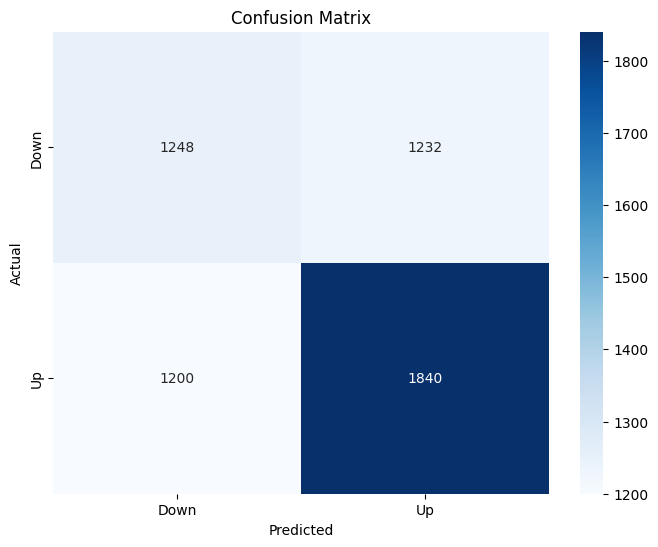

In [15]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f"F1 score {f1_score(y_test, y_pred)}")
print(f"Precision score {precision_score(y_test, y_pred)}")
print(f"Recall score {recall_score(y_test, y_pred)}")

F1 score 0.6020942408376964
Precision score 0.5989583333333334
Recall score 0.6052631578947368


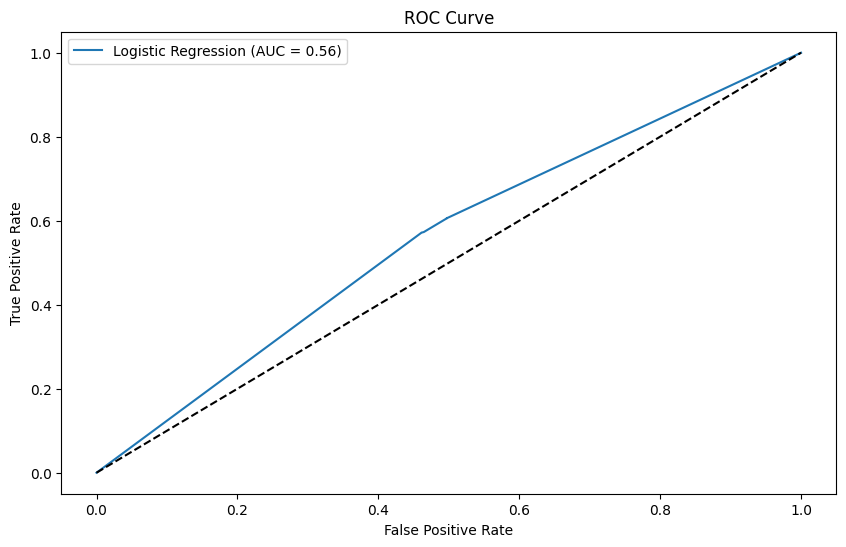

AUC : 0.5566674182937181


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred_prob)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC : {roc_auc}")

In [18]:
feat_imp = pd.DataFrame({"Variable" : model.feature_names_in_,
                         "Importance" : model.feature_importances_})

feat_imp.sort_values("Importance", ascending=False).head(20)

,Variable,Importance
142,Earnings Yield,0.033415
185,Weighted Average Shares Diluted Growth,0.014769
71,Effect of forex changes on cash,0.014269
18,Weighted Average Shs Out,0.013182
205,SG&A Expenses Growth,0.011992
58,Other Assets,0.011317
66,Investing Cash flow,0.010832
138,EV to Sales,0.010737
191,5Y Operating CF Growth (per Share),0.010710
1,Revenue Growth,0.009654


In [19]:
model = DecisionTreeClassifier(max_depth=6, 
                               class_weight=class_weights_td)

model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 7438, 1: 9119}, max_depth=6)

In [20]:
model.score(X_train, y_train)

0.6370719333212539

In [21]:
model.score(X_test, y_test)

0.6103260869565217

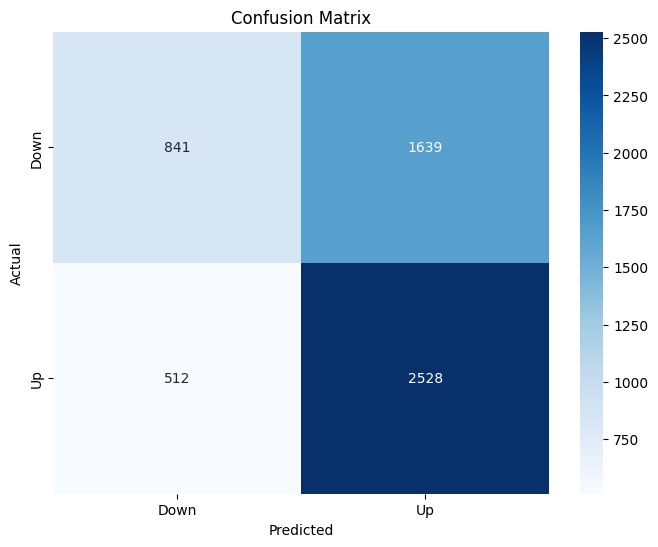

In [22]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(f"F1 score {f1_score(y_test, y_pred)}")
print(f"Precision score {precision_score(y_test, y_pred)}")
print(f"Recall score {recall_score(y_test, y_pred)}")

F1 score 0.7015401692798668
Precision score 0.6066714662826974
Recall score 0.8315789473684211


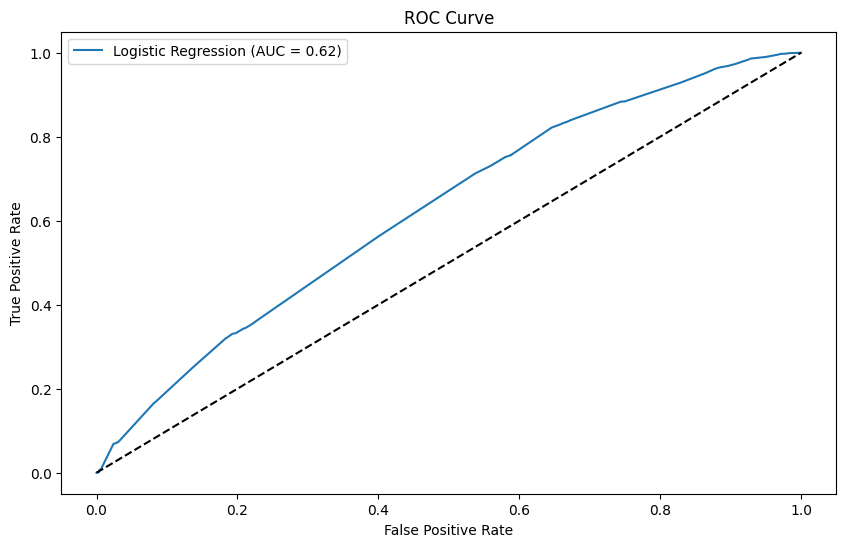

AUC : 0.624266898344652


In [24]:
roc_auc = roc_auc_score(y_test, y_pred_prob)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC : {roc_auc}")